## Import libraries

In [3]:
import pandas as pd 
import seaborn as sns 
import numpy as np 

import category_encoders as ce 

import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_predict, validation_curve, learning_curve

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer

import ast

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [4]:
pd.set_option('display.max_columns', 50)

## Load datasets

A quick look into the dataset and we could notice that the special character _"\N"_ is used instead of _NaN_ for missing values.

In [5]:
# X1: entry dataset (note: X2 is the testing dataset)
# use row `Unamed: 0` as the row index
X1 = pd.read_csv("datasets/X1.csv", na_values="\\N")
X1.head()

,Unnamed: 0,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
0,2502,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105.0,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,6238,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,NaN,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,1800,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127.0,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,2675,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105.0,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,3674,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108.0,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."


In [6]:
#X1.loc[X1["title"] == "Clown"]

inputs dataset has dimension (3540, 14)

One first thing we can notice is that our dataset use a special character "\\N" for empty values. We should modify them to NaN.

In [7]:
# Y1: target dataset
Y1 = pd.read_csv("datasets/Y1.csv", header=None, names=["revenues"])
Y1.head()

,revenues
0,7.158530e+07
1,8.964834e+04
2,3.164907e+07
3,3.898197e+07
4,9.697023e+06


target dataset has dimension (3540, 1)

In [8]:
# X2: testing entry dataset
X2 = pd.read_csv("datasets/X2.csv", na_values="\\N")

In [9]:
print(f"X1 dataset contains {X1.shape[0]} observations and {X1.shape[1]} features")
print(f"X2 dataset (for prediction only) contains {X2.shape[0]} observations")

print(f"features: {list(X1.columns)}")
print(f"target: {list(Y1.columns)}")

X1 dataset contains 3540 observations and 14 features
X2 dataset (for prediction only) contains 1518 observations
features: ['Unnamed: 0', 'title', 'img_url', 'description', 'ratings', 'n_votes', 'is_adult', 'production_year', 'runtime', 'genres', 'release_year', 'studio', 'img_embeddings', 'text_embeddings']
target: ['revenues']


## Dataset description

inputs (X1):     
- `title`: title of the movie.    
- `ratings`: rating on IMDB.    
- `n_votes`: number of votes that are averaged for the given rating.    
- `is_adult`: is the movie destined for a mature audience (0 or 1).    
- `production_year`: the year the movie was produced.    
- `release_year`: the year the movie was released.    
- `runtime`: how long the movie lasts for (in minutes).    
- `genres`: a list of maximum 3 genres that fits the movie.   
- `studio`: the movie studio that produced the movie.        
- `img.url`: the url of the poster of the movie.    
- `img.embeddings`: vector of size 2048 representing the poster.    
- `description`: synopsis of the movie.    
- `text.embeddings`: vector of size 768 representing the synopsis.

There is also an `"Unnamed: 0"` column that seems to be an **id for the movie**. We can remove it.

target (Y1):     
- `revenue`: the amount in dollars the movie made in the USA.    

In [10]:
# drop unecessary column `Unnamed: 0`
X1.drop("Unnamed: 0", axis=1, inplace=True)

For feature engineering and the sake of simplicity, we're gonna concatenate the inputs `X1` with the target `Y1`

In [11]:
df = pd.concat([X1, Y1], axis = 1)
df.head()

,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
0,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105.0,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934...",7.158530e+07
1,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,NaN,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04
2,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127.0,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415...",3.164907e+07
3,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105.0,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693...",3.898197e+07
4,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108.0,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391...",9.697023e+06


## EDA

### Types of variables

First, let's rename `Unnamed: 0` column to `movie_id`

Let's check the different types of variables

In [12]:
# types of variables
df.dtypes.value_counts()

object     7
float64    5
int64      2
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540 entries, 0 to 3539
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            3540 non-null   object 
 1   img_url          3540 non-null   object 
 2   description      3540 non-null   object 
 3   ratings          3540 non-null   float64
 4   n_votes          3540 non-null   float64
 5   is_adult         3540 non-null   int64  
 6   production_year  3540 non-null   int64  
 7   runtime          3276 non-null   float64
 8   genres           3536 non-null   object 
 9   release_year     3540 non-null   float64
 10  studio           3540 non-null   object 
 11  img_embeddings   3540 non-null   object 
 12  text_embeddings  3540 non-null   object 
 13  revenues         3540 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 387.3+ KB


- `n_votes` and `release_year` are of type **float** but we could have thought they would be of type **int**.

In [14]:
df["n_votes"].unique()

array([9.2937e+04, 1.1000e+01, 1.3450e+03, ..., 2.2860e+03, 4.1810e+03,
       2.7379e+04])

In [15]:
df["release_year"].unique()

array([2010., 2014., 1978., 1994., 1982., 2000., 1990., 2002., 1997.,
       2009., 2001., 2003., 2007., 1992., 1998., 1995., 2008., 1983.,
       2015., 1991., 2016., 2006., 1973., 2004., 2011., 1999., 1986.,
       2005., 1996., 2013., 1993., 1989., 2012., 1987., 1988., 2017.,
       1980., 1985., 1981., 1979., 1984., 1977., 2018., 1946., 1975.,
       1966., 1971., 1974., 1941., 1957., 1970., 1976., 1972., 1959.])

For sure we could convert `release_year` to type **int**.

### Duplicated observations

Let's check if we have any duplicate observations (we saw before that there could be duplicated movies with different `movie_id`)

In [16]:
df[df.duplicated(subset=df.columns.difference(["revenues"]))].count()

title              432
img_url            432
description        432
ratings            432
n_votes            432
is_adult           432
production_year    432
runtime            395
genres             431
release_year       432
studio             432
img_embeddings     432
text_embeddings    432
revenues           432
dtype: int64

We have 432 duplicated observations

### Missing values

Let's see if there is any empty values

In [17]:
df.isna().sum()

title                0
img_url              0
description          0
ratings              0
n_votes              0
is_adult             0
production_year      0
runtime            264
genres               4
release_year         0
studio               0
img_embeddings       0
text_embeddings      0
revenues             0
dtype: int64

In [18]:
# number of missing values
X2.isna().sum()

Unnamed: 0           0
title                0
img_url              0
description          0
ratings              0
n_votes              0
is_adult             0
production_year      0
runtime            106
genres               4
release_year         0
studio               0
img_embeddings       0
text_embeddings      0
dtype: int64

Dataset for modelling :
There are 264 missing values for `runtime` feature and 4 missing values for `genres` feature.

Dataset for prediction :
There are 106 missing values for `runtime` feature and 4 missing values for `genres` feature.

In [19]:
# percentage of missing values
((df.isna().sum() / df.shape[0]) * 100).round(decimals = 2)

title              0.00
img_url            0.00
description        0.00
ratings            0.00
n_votes            0.00
is_adult           0.00
production_year    0.00
runtime            7.46
genres             0.11
release_year       0.00
studio             0.00
img_embeddings     0.00
text_embeddings    0.00
revenues           0.00
dtype: float64

In [20]:
((X2.isna().sum() / X2.shape[0]) * 100).round(decimals = 2)

Unnamed: 0         0.00
title              0.00
img_url            0.00
description        0.00
ratings            0.00
n_votes            0.00
is_adult           0.00
production_year    0.00
runtime            6.98
genres             0.26
release_year       0.00
studio             0.00
img_embeddings     0.00
text_embeddings    0.00
dtype: float64

<AxesSubplot:>

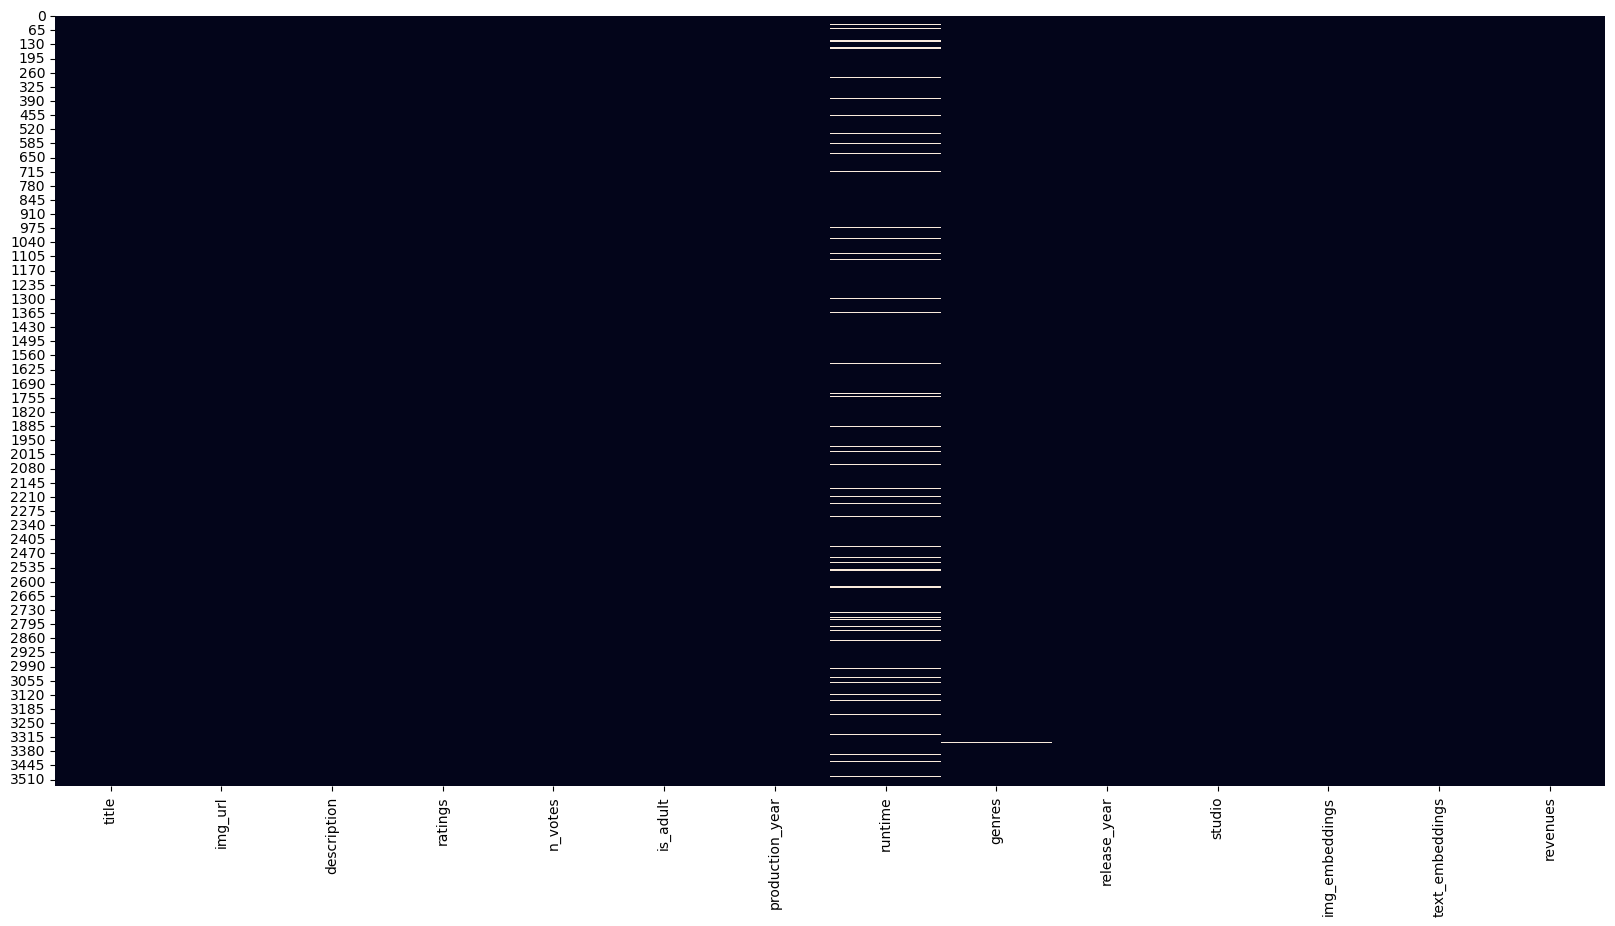

In [21]:
plt.figure(figsize = (20, 10))
sns.heatmap(df.isna(), cbar = False)

Let's check the rows containing missing values

In [22]:
df.loc[df.isna().any(axis=1)]

,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
1,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,NaN,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04
9,Change of Plans,https://m.media-amazon.com/images/M/MV5BMDFhZj...,Change of Plans: Directed by Randy Zisk. With ...,8.2,12.0,0,1992,NaN,"Crime,Drama",2010.0,IFC,"[0.20134872, 3.3128614, 1.3217659, 0.05505188,...","[-0.7538657, 0.43110898, 0.9997868, -0.9895797...",6.305640e+04
38,Clown,https://m.media-amazon.com/images/M/MV5BMjBiOD...,Clown: Directed by Steve Lyons. With Jeff Benn...,8.6,5.0,0,2001,NaN,"Animation,Comedy,Family",2016.0,W/Dim.,"[0.14516667, 0.06064418, 0.15632975, 0.1824489...","[-0.65403396, 0.3780646, 0.999505, -0.97987425...",6.747525e+04
41,Rugrats in Paris: The Movie,https://m.media-amazon.com/images/M/MV5BYzBiNW...,Rugrats in Paris: The Movie: With Cheryl Chase...,6.4,74.0,0,2000,NaN,"Action,Adventure,Comedy",2000.0,Par.,"[0.47641614, 0.82069486, 0.22295909, 0.1736825...","[-0.68661237, 0.37858504, 0.9997692, -0.978913...",1.308007e+08
57,In Bloom,https://m.media-amazon.com/images/M/MV5BYWNmZj...,In Bloom: Directed by Marc Buckland. With Neal...,8.4,16.0,0,2004,NaN,"Drama,Mystery",2014.0,BWP,"[0.30072853, 3.2013667, 0.42100322, 0.10732664...","[-0.787354, 0.46719107, 0.9998723, -0.9922189,...",6.976546e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,The Channel,https://m.media-amazon.com/images/M/MV5BNzAwOT...,The Channel: Directed by Jorge Montesi. With S...,7.3,26.0,0,1999,NaN,"Adventure,Drama,Mystery",2016.0,Indic.,"[0.3205554, 0.3742889, 0.11509394, 0.9490364, ...","[-0.60545, 0.31592008, 0.9992462, -0.97367644,...",2.247131e+04
3495,Darshan,https://m.media-amazon.com/images/M/MV5BN2Y2Zj...,Darshan: Directed by Chimanlal Luhar. With Pre...,7.0,8.0,0,1941,NaN,NaN,2006.0,IFC,"[0.056906767, 0.1291496, 0.07299683, 0.0496285...","[-0.7949531, 0.46442604, 0.99984866, -0.991559...",9.642768e+04
3496,Dog Days of Summer,https://m.media-amazon.com/images/M/MV5BMjExNj...,"Dog Days of Summer: Directed by Chris Buck, Cl...",6.2,6.0,0,1993,NaN,"Animation,Comedy,Family",2008.0,MTop,"[0.21031177, 0.622036, 0.10827673, 0.14782186,...","[-0.672096, 0.35698575, 0.9996098, -0.98000515...",7.360684e+03
3504,Area 51,https://m.media-amazon.com/images/M/MV5BMjE4Nz...,"Area 51: With Tom Kane, Joerg Arnu, T.D. Barne...",5.7,6.0,0,2004,NaN,Documentary,2015.0,PARAIN,"[0.68146044, 1.8886466, 2.4086003, 0.9816384, ...","[-0.6459968, 0.31116134, 0.99957985, -0.981476...",9.386019e+03


**Rule of thumb**: _if values are missing at random and percentage of observations with these missing values are less than $5\%$. We can drop them without risking of creating bias in our dataset._

We have $0.3\%$ of entries with missing values for `genres` features. These are random missing values (no reason for these to be missing, probably forgotten) so we can definitelty drop these entries without risk of creating bias in our dataset.
However, for the `runtime` feature, we have ~ $7\%$ of missing values. That's a little bit much for removing all these entries even though they also seem to be random missing values.

We could try to impute by mean or something else.

0    90.0
Name: runtime, dtype: float64


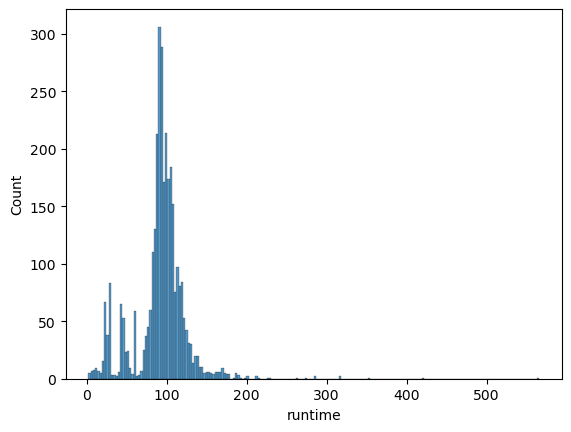

In [23]:
sns.histplot(df["runtime"])

print(df["runtime"].mode())

If data is missing randomly but the rows with these missing values are more than $5\%$ of the dataset, we can use **mean** (in case feature is normally distributed) or **median** (otherwise) imputation. We can also consider **mode** imputation.

However, keep in mind it affects data distribution (in particular the variance is reduced).

In [24]:
print("runtime mean: {}".format(df["runtime"].mean()))
print("runtime median: {}".format(df["runtime"].median()))
print("runtime mode: {}".format(df["runtime"].mode()))

runtime mean: 92.29334554334554
runtime median: 95.0
runtime mode: 0    90.0
Name: runtime, dtype: float64


### Analysis of features

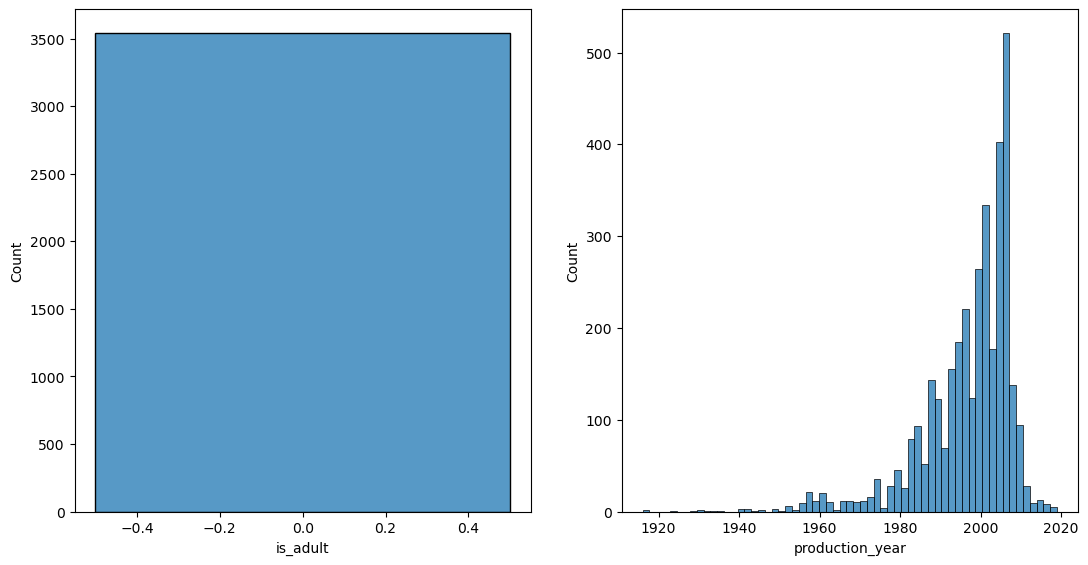

In [25]:
plt.subplots(figsize=(20,30))

i = 1

for col in df.select_dtypes("int"):
    plt.subplot(4,3,i)
    sns.histplot(df[col])
    i += 1

There seems to be only _non-adult_ movies (to confirm later).

Movies were mainly produced between **1990** and **2010**. We have a slightly left skewed distribution but it is more or less **normally distributed**.

In [26]:
df["is_adult"].value_counts()

0    3540
Name: is_adult, dtype: int64

Indeed, we **do not have any movies** for a _mature audience_. 
Therefore, we could drop this column.

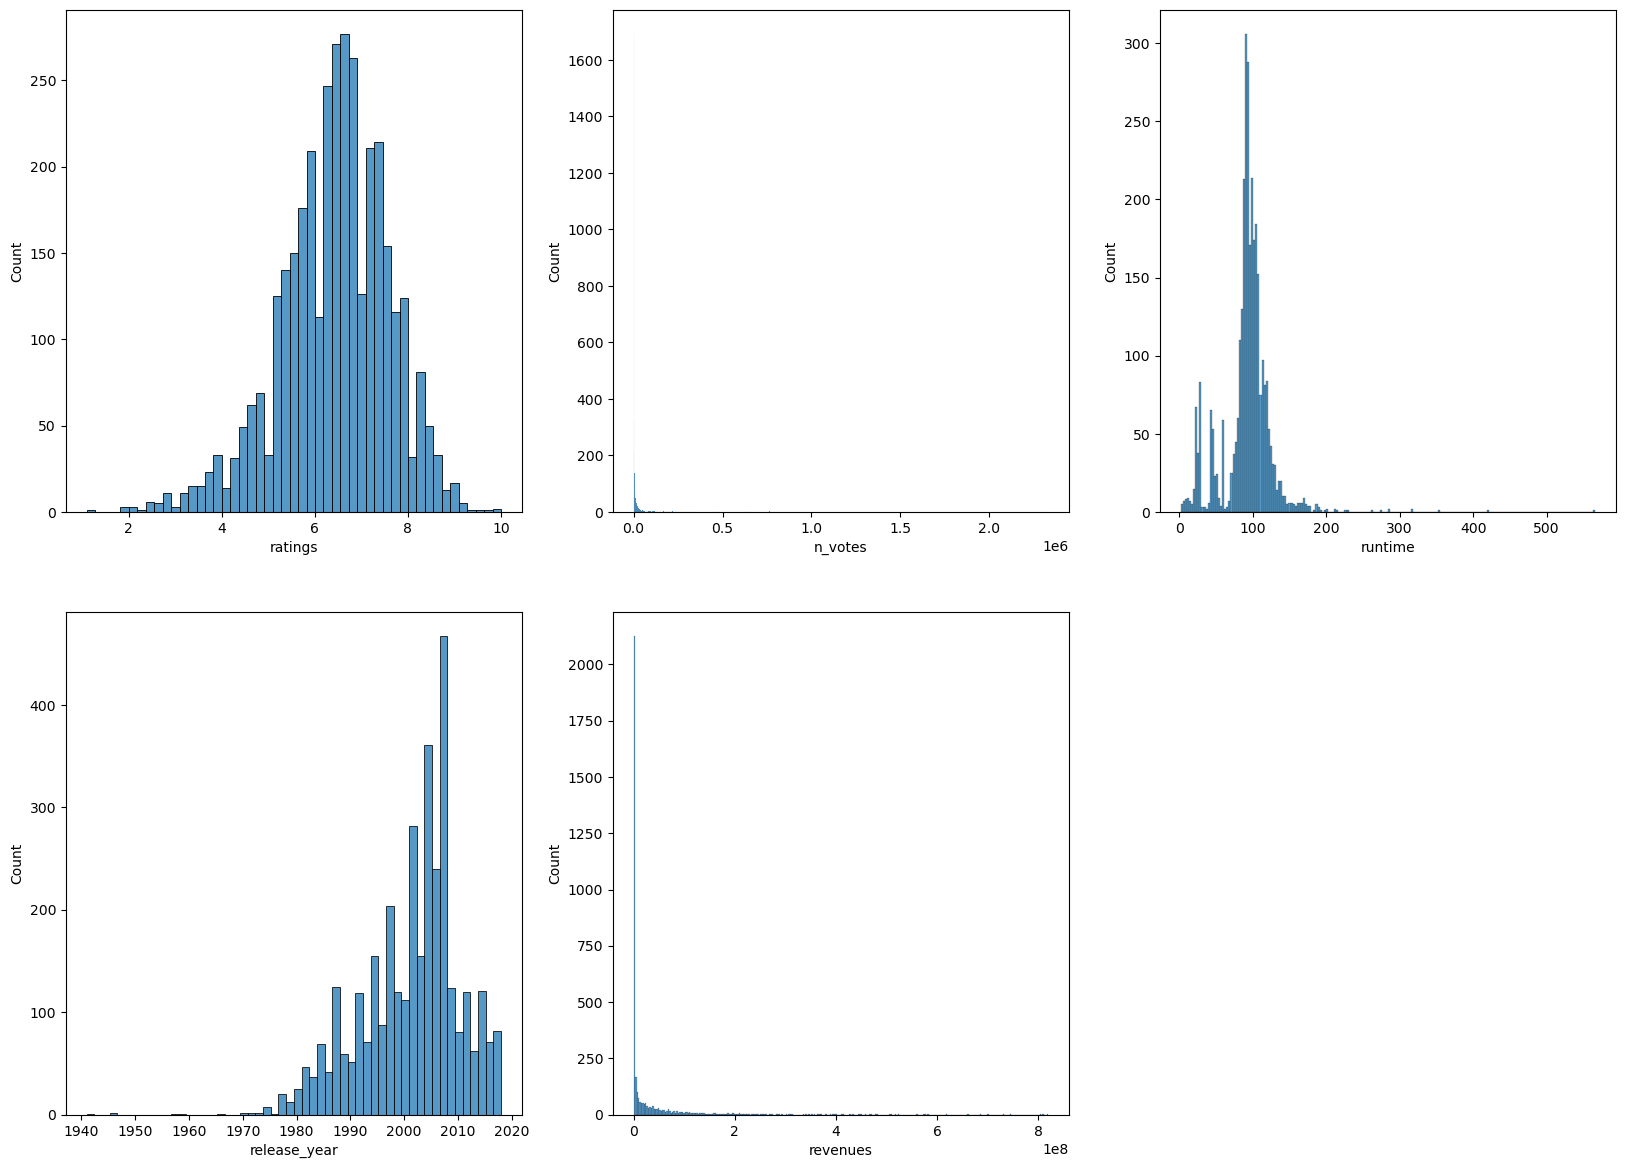

In [27]:
plt.subplots(figsize=(20,30))

i = 1

for col in df.select_dtypes("float"):
    plt.subplot(4, 3, i)
    sns.histplot(df[col])
    i += 1

- `ratings`, `runtime` and `release_year` features are more or less **normally distributed**.

- `ratings` have a mean around **6.5**.

- Most movies were released between **2005** and **2010**. 

- `n_votes` feature and `revenues` target are **heavily right skewed**. We will have to manage that.

### Skewness and outliers analysis

In [28]:
df.skew().sort_values(ascending=False)

/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_6971/4024944668.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew().sort_values(ascending=False)


n_votes            10.779527
revenues            5.082127
runtime             1.470029
is_adult            0.000000
ratings            -0.518066
release_year       -0.802386
production_year    -1.902448
dtype: float64

<AxesSubplot:ylabel='n_votes'>

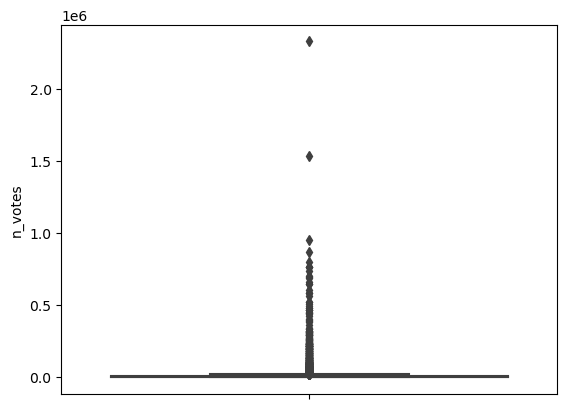

In [29]:
sns.boxplot(y = df["n_votes"])

<AxesSubplot:ylabel='revenues'>

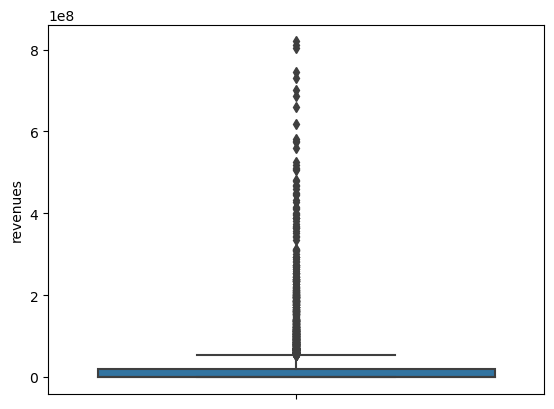

In [30]:
sns.boxplot(y = df["revenues"])

<AxesSubplot:ylabel='n_votes'>

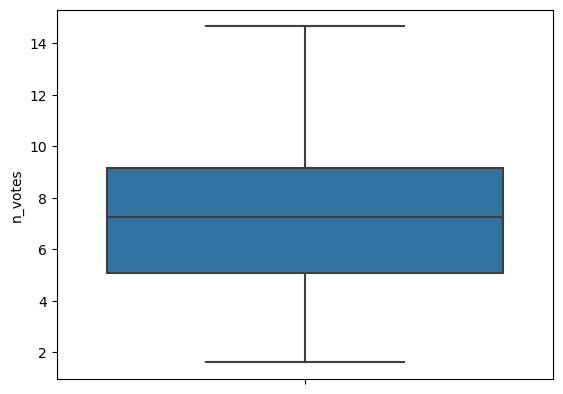

In [31]:
sns.boxplot(y = np.log(df["n_votes"]))

<AxesSubplot:xlabel='n_votes', ylabel='Count'>

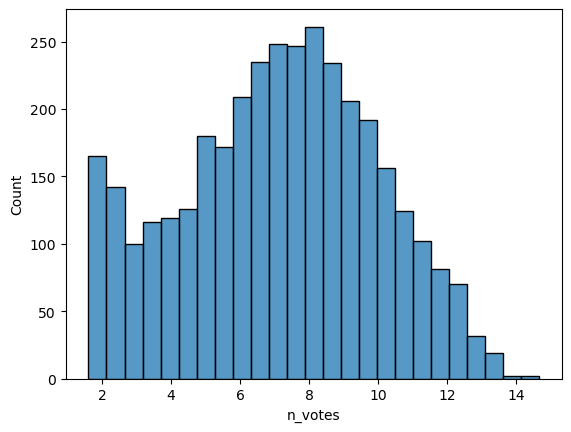

In [32]:
sns.histplot(np.log(df["n_votes"]))

<AxesSubplot:ylabel='revenues'>

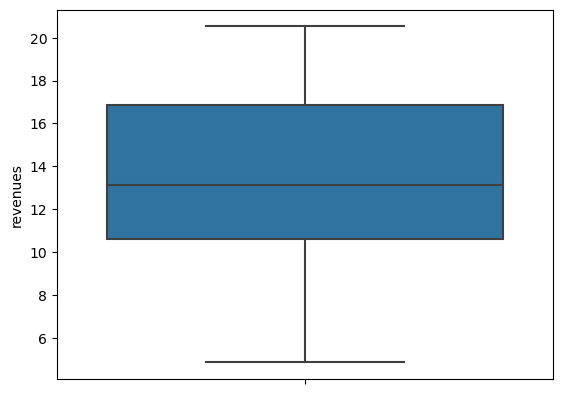

In [33]:
sns.boxplot(y = np.log(df["revenues"]))

<AxesSubplot:xlabel='revenues', ylabel='Count'>

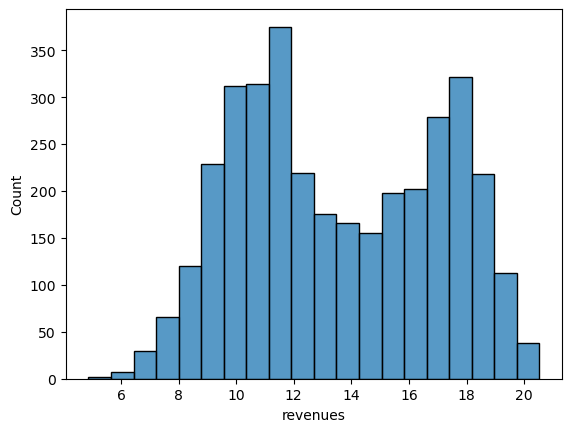

In [34]:
sns.histplot(np.log(df["revenues"]))

For these two variables, 50% of the data are concentrated on a small range of values. But they contain a lot of outliers until pretty high values (that's why distribution is heavily right skewed).

We see that we can perform a **log** transform on the 2 features to fix the skewness.

In [35]:
df.describe()

,ratings,n_votes,is_adult,production_year,runtime,release_year,revenues
count,3540.000000,3.540000e+03,3540.0,3540.000000,3276.000000,3540.000000,3.540000e+03
mean,6.426582,2.337422e+04,0.0,1996.867232,92.293346,2001.375706,2.808340e+07
std,1.166002,8.597705e+04,0.0,11.818582,32.619486,9.236620,7.322589e+07
min,1.100000,5.000000e+00,0.0,1916.000000,2.000000,1941.000000,1.303869e+02
25%,5.800000,1.577500e+02,0.0,1992.000000,85.000000,1996.000000,4.155345e+04
50%,6.500000,1.412000e+03,0.0,2000.000000,95.000000,2003.000000,5.019854e+05
75%,7.200000,9.424500e+03,0.0,2005.000000,106.000000,2007.000000,2.144866e+07
max,10.000000,2.332286e+06,0.0,2019.000000,566.000000,2018.000000,8.199476e+08


Let's analyze the range of the different numericals features

In [36]:
(df.select_dtypes(include=["int64", "float64"]).max() - df.select_dtypes(include=["int64", "float64"]).min()).round(decimals=3)

ratings            8.900000e+00
n_votes            2.332281e+06
is_adult           0.000000e+00
production_year    1.030000e+02
runtime            5.640000e+02
release_year       7.700000e+01
revenues           8.199474e+08
dtype: float64

Finally we count the number of unique values for the 2 categorical features `genres` and `studio`.

In [37]:
df["genres"].describe()

count      3536
unique      351
top       Drama
freq        313
Name: genres, dtype: object

`genre` feature contains list of maximum 3 most representative genres for each movies so there are many differents list of genres which does not mean there a as much different genres. We should preprocess them before then count how many different genres there are. 
However, we can expect there shouldn't be too many differents.

In [38]:
df["studio"].describe()

count     3540
unique     498
top         WB
freq       184
Name: studio, dtype: object

We see there are $498$ different studios (**high-cardinality** problem), therefore, it will result in a lof of features if we One-Hot encode them. As a consequence, we would explose the dimensionnality of the datas and there would be more risk to overfit (curse of dimensionnality). Better to Label encode ? Let's check first the distribution of this feature

In [39]:
from collections import Counter

Counter(df["studio"]).most_common()

[('WB', 184),
 ('Uni.', 151),
 ('BV', 144),
 ('Par.', 128),
 ('Fox', 115),
 ('Mira.', 113),
 ('Sony', 103),
 ('IFC', 95),
 ('MGM', 89),
 ('Magn.', 65),
 ('NL', 60),
 ('SPC', 60),
 ('Strand', 54),
 ('Col.', 51),
 ('Lions', 46),
 ('FoxS', 45),
 ('Reg.', 42),
 ('FRun', 40),
 ('Indic.', 39),
 ('Eros', 37),
 ('Orion', 35),
 ('Think', 35),
 ('Gold.', 33),
 ('TriS', 32),
 ('Palm', 26),
 ('FL', 25),
 ('Gram.', 24),
 ('IDP', 23),
 ('First', 22),
 ('Focus', 22),
 ('Art.', 21),
 ('Truly', 20),
 ('NYer', 20),
 ('LGF', 20),
 ('SGem', 20),
 ('Zeit.', 20),
 ('RAtt.', 20),
 ('AL', 20),
 ('Kino', 19),
 ('MBox', 18),
 ('FM', 18),
 ('Free', 17),
 ('CLS', 17),
 ('7Art', 17),
 ('ParC', 16),
 ('Castle', 15),
 ('Trim.', 15),
 ('Can.', 15),
 ('UA', 15),
 ('Wein.', 14),
 ('Anch.', 14),
 ('KL', 14),
 ('Bal.', 14),
 ('Shad.', 14),
 ('USA', 14),
 ('Vita.', 14),
 ('Mont.', 13),
 ('ICir', 13),
 ('UTV', 13),
 ('Abr.', 13),
 ('Scre.', 12),
 ('DW', 12),
 ('WIP', 12),
 ('Oct.', 12),
 ('Slow', 11),
 ('SonR', 11),
 ('NW'

There are some studio that only appear one time. We could definitely remove them and replace them by a category called `other`. Then One-Hot encode this feature.

Or, we can also try "Count Encoding" that replaces each `studio` value with the number of times it appears in the dataset

## Preprocessing (part 1)

### Remove duplicated observations and preprocessing missing values

In [40]:
def preprocess_duplicated_and_missing(df):
	# drop duplicated values
	df.drop_duplicates(subset=df.columns.difference(["revenues"]), keep="first", inplace=True)

	# drop observations with missing genres
	df.dropna(subset=["genres"], axis=0, inplace=True)

	# impute observations with missing runtime (because > 5% of missing values)
	# replace by the mean (since runtime feature is not too for from a Gaussian)
	df["runtime"].fillna(df["runtime"].mean(), inplace=True)

	print("[X] Removing duplicated and missing values")
	return df

### Remove (obvious) irrelevant/redundant features

In [41]:
def preprocess_irrelevant_features(df):
	# drop `img_url` and `description` since we have the embeddings
	df.drop(["img_url", "description"], axis=1, inplace=True)

	# we do not have movies for mature audience so feature `is_adult` has variance 0
	df.drop(["is_adult"], axis=1, inplace=True)

	print("[X] Removing irrelevant features")
	return df

### One-Hot Encode genres feature

In [42]:
def one_hot_encode_genres_feature(df):
	# separate all genres into one big list of list of genres
	genres_list = df["genres"].str.split(",").tolist()

	unique_genres = []

	# retrieve each genre
	for sublist in genres_list:
		for genre in sublist:
			if genre not in unique_genres:
				unique_genres.append(genre)

	# sort
	unique_genres = sorted(unique_genres)

	# one hot encode movies genres
	df = df.reindex(df.columns.tolist() + unique_genres, axis=1, fill_value=0)

	for index, row in df.iterrows():
		for genre in row["genres"].split(","):
			df.loc[index, genre] = 1

	# drop old genres column
	df.drop("genres", axis=1, inplace=True)

	print("[X] One-Hot encoding")
	return df

### Label Encode studio feature

In [43]:
label_encoder_studio = LabelEncoder()

def label_encode_studio_feature(df):
	df["studio"] = label_encoder_studio.fit_transform(df["studio"].to_numpy())

	print("[X] Label encoding")
	return df

### Count Encode studio feature

In [44]:
count_encoder_studio = ce.CountEncoder()

def count_encode_studio_feature(df):
	df["studio"] = count_encoder_studio.fit_transform(df["studio"])

	print("[X] Count encoding")
	return df

### Minor fixes

In [45]:
def other_fixes(df):
	# it does not make sense to have `release_year` and `n_votes` features as type float
	# let's convert them into int
	df["release_year"] = df["release_year"].astype(int)
	#df["n_votes"] = df["n_votes"].astype(int)

	# log-transform `n_votes` and `revenues` features to fix the skweness
	df["n_votes"] = np.log(df["n_votes"])

	if "revenues" in df:
		df["revenues"] = np.log(df["revenues"])

	# in notebook, I dropped this feature at the end of first part of preprocessing
	# but I'm not sure why
	df.drop("title", axis=1, inplace=True)

	print("[X] Minor fixes")
	return df

In [46]:
def preprocess(df, dataset_name):
	print(f"PREPROCESSING {dataset_name} 1/2...")
	print("--------------------------")
	df = preprocess_duplicated_and_missing(df)
	df = preprocess_irrelevant_features(df)

	df = one_hot_encode_genres_feature(df)
	#df = label_encode_studio_feature(df)
	df = count_encode_studio_feature(df)
	df = other_fixes(df)
	return df

df = preprocess(df, "modeling dataset")
X2 = preprocess(X2, "prediction dataset")

PREPROCESSING modeling dataset 1/2...
--------------------------
[X] Removing duplicated and missing values
[X] Removing irrelevant features
[X] One-Hot encoding
[X] Count encoding
[X] Minor fixes
PREPROCESSING prediction dataset 1/2...
--------------------------
[X] Removing duplicated and missing values
[X] Removing irrelevant features
[X] One-Hot encoding
[X] Count encoding
[X] Minor fixes


## Preprocessing (part 2)

### Handle outliers

In [47]:
def remove_outliers(X_train):
	pass

### Standardizing

Standardizing data with `Standadardizer` or `Normalizer` is not a good idea with skewed data. 
Since we cannot remove outliers of `n_votes` feature, we use `RobustScaler` that works better with skewed data.

**UPDATE**: skewness fixed with _log-transform_ so every features follow more or less a normal distribution. We can standardize data with StandardScaler.

In [48]:
standard_scaler = StandardScaler()

def standardize(X_train, X_test):
	# fit the scaler on training dataset
	X_train_scaled = standard_scaler.fit_transform(X_train)

	# apply the scaler on testing dataset (and so avoid introducing bias)
	X_test_scaled = standard_scaler.transform(X_test)

	# should do the same on X2 

	X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
	X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

	return X_train, X_test

### Extracting features from embeddings

In [49]:
def extract_embeddings_features(embeddings):
	"""
	Args:
		embeddings (pd.Series): Pandas Series of string representation of feature vectors.
	Return:
		(np.ndarray): feature matrix of dimension (n_observations, n_features)
	"""
	n = embeddings.shape[0]
	embeddings_matrix = []

	for i in range(n):
		# embeddings are encoded as string representation of vector
		# convert these into list
		# Note: should'nt set ast.litteral_eval(...) to a variable, then append to the list
		# since it would consume a huge quantity of ram.
		# better directly appending
		embeddings_matrix.append(ast.literal_eval(embeddings.iloc[i]))

	return embeddings_matrix

### Running PCA on embeddings

Embeddings are feature vectors which means each number in the vector represent a feature. 
For example, it could be `feature_vector = [R, G, B]` where `R`, `G` and `B` are integers value and represent red, green, blue quantity of an image. 
We extract these features and put them into columns. We should note it's gonna give us a very high dimension dataset.

In [50]:

def pca_on_embeddings(train_embeddings_matrix, test_embeddings_matrix, train_index, test_index, prefix, total_variance_explained = 0.95):
		scaler = StandardScaler()

		n_features_before_pca = len(train_embeddings_matrix[0])

		# standardize data
		train_embeddings_matrix = scaler.fit_transform(train_embeddings_matrix)
		test_embeddings_matrix = scaler.transform(test_embeddings_matrix)

		pca = PCA(n_components=total_variance_explained)

		# run pca
		train_embeddings_matrix = pca.fit_transform(train_embeddings_matrix)
		test_embeddings_matrix = pca.transform(test_embeddings_matrix)

		print(f"successfully reduced from {n_features_before_pca} features to {len(train_embeddings_matrix[0])} features keeping {total_variance_explained * 100}% of variance explained")

		train_embeddings_df = pd.DataFrame(train_embeddings_matrix, index=train_index).add_prefix(prefix)
		test_embeddings_df = pd.DataFrame(test_embeddings_matrix, index=test_index).add_prefix(prefix)

		return train_embeddings_df, test_embeddings_df

In [51]:
def special_preprocess(X, Y):
	print("PREPROCESSING 2/2...")
	print("--------------------------")

	X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, shuffle = True, random_state = 0)

	print(f"training dataset dimension: X_train: {X_train.shape}, y_train: {y_train.shape}")
	print(f"testing dataset dimension: X_test: {X_test.shape}, y_test: {y_test.shape}")

	# remove outliers only on train set
	# as test set should be representative of the reality
	#remove_outliers(X_train)

	# extract feature vectors
	X_train_img_embeddings = extract_embeddings_features(X_train["img_embeddings"])
	X_test_img_embeddings = extract_embeddings_features(X_test["img_embeddings"])

	X_train_text_embeddings = extract_embeddings_features(X_train["text_embeddings"])
	X_test_text_embeddings = extract_embeddings_features(X_test["text_embeddings"])

	X_train_img_df, X_test_img_df = pca_on_embeddings(X_train_img_embeddings, X_test_img_embeddings, X_train.index, X_test.index, prefix="img_feature", total_variance_explained=0.8)

	X_train_text_df, X_test_text_df = pca_on_embeddings(X_train_text_embeddings, X_test_text_embeddings, X_train.index, X_test.index, prefix="text_feature", total_variance_explained=0.8)

	# drop unnecessary features
	X_train.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)
	X_test.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)

	# standardize other features
	X_train, X_test = standardize(X_train, X_test)

	X_train = pd.concat([X_train, X_train_img_df, X_train_text_df], axis=1)
	X_test = pd.concat([X_test, X_test_img_df, X_test_text_df], axis=1)

	# should also extract features for X2

	return X_train, X_test, y_train, y_test

X = df.drop("revenues", axis=1)
Y = df["revenues"]

X_train, X_test, y_train, y_test = special_preprocess(X, Y)

PREPROCESSING 2/2...
--------------------------
training dataset dimension: X_train: (2484, 34), y_train: (2484,)
testing dataset dimension: X_test: (621, 34), y_test: (621,)
successfully reduced from 2048 features to 125 features keeping 80.0% of variance explained
successfully reduced from 768 features to 3 features keeping 80.0% of variance explained


## Model

We're gonna build regression models :
- Linear regression
- K-Nearest Neighbors 
- MLP
- One other non-linear method (can be one not seen during the course)

We're gonna do **feature selection** and **model selection**.
/!\ model selection can require a lot of computation time /!\

We're gonna validate the model.

### Feature selection : filter method

We want to remove redundant or irrelevant features to improve computational efficiency and reduce the risk of overfitting.
As I understand, there's multiple ways to selection features via filter method. As a reminder, filter method is independent of any machine learning model but does not take into account feature redundancy. 

Some of them are:
- `Chi-Square` and `ANOVA`: for categorical variables and categorical targets    
- `Correlation matrix`: for continuous variables, continuous target and linear model    
- `Mutual information`: for continuous variables, continuous target and non-linear model     

Since we're dealing with continuous target and we will train linear and non-linear models, we use the two last one.

#### Correlation matrix (linear models)

A feature perfectly correlated with another one does not apport any new informations but add complexity to the model. Moreover, features with correlation coefficient close to 1 can be redundant if they share the same information. However, the correlation coefficient only makes sense when the features are linear between each other. If the relation between two features is non-linear, it can produce weird problems. In order to avoid that, we can use the mutual information gain.

Index(['ratings', 'n_votes', 'production_year', 'runtime', 'release_year',
       'studio', 'Action', 'Adventure', 'Animation', 'Biography',
       ...
       'img_feature118', 'img_feature119', 'img_feature120', 'img_feature121',
       'img_feature122', 'img_feature123', 'img_feature124', 'text_feature0',
       'text_feature1', 'text_feature2'],
      dtype='object', length=160)


<AxesSubplot:>

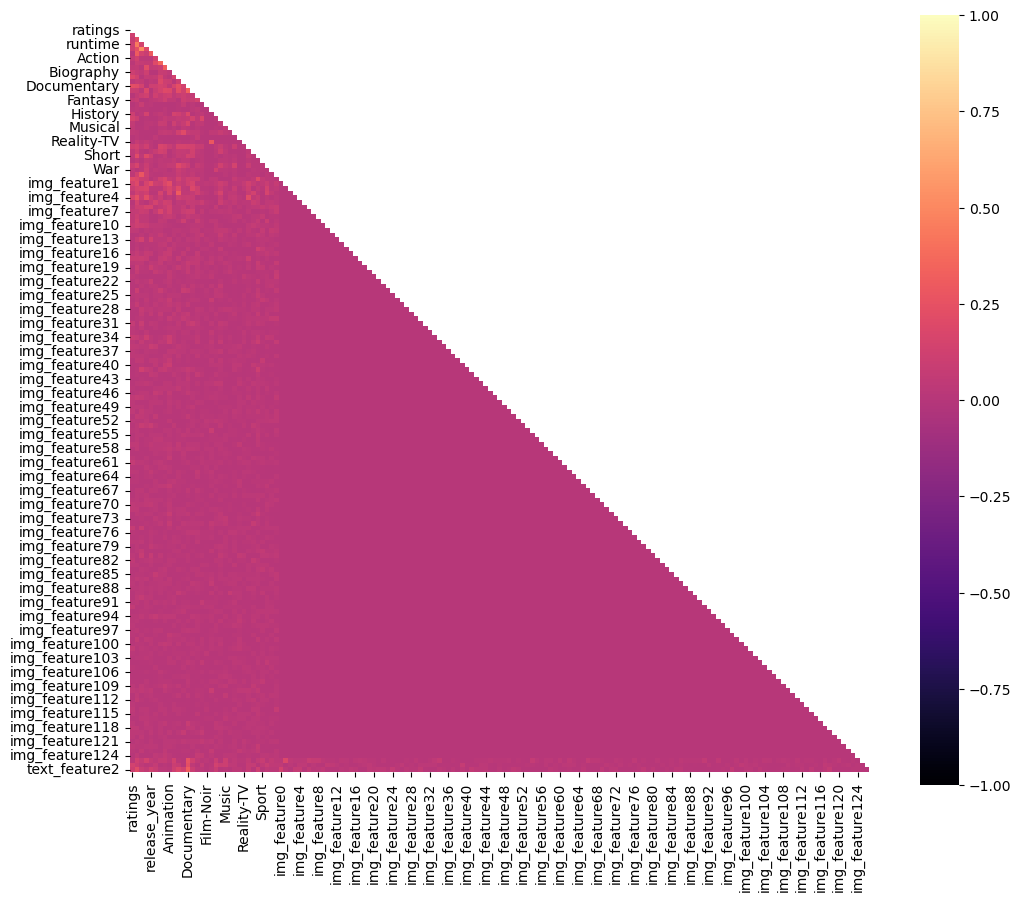

In [52]:
fig = plt.subplots(figsize = (12,10))

corr_matrix = X_train.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

tri_df = corr_matrix.mask(mask)
print(tri_df.columns)

sns.heatmap(corr_matrix, mask=mask, cmap="magma", square=True, vmin=-1, vmax=1, center=0, annot=False)

In [53]:
def select_features_correlation(X_train, y_train, X_test, k_features):
    # select k best features according to correlation matrix
    k_best = SelectKBest(score_func=f_regression, k=k_features)
    k_best.fit(X_train, y_train)
    #print(X_train.columns[k_best.get_support()])
    
    X_train_filtered = X_train[k_best]
    X_test_filtered = X_test[k_best]
    
    return X_train_filtered, X_test_filtered

#### Mutual information (non-linear models)

In [54]:
def select_features_MI(X_train, y_train, X_test, k_features):
    # select k best features according to MI
    k_best = SelectKBest(score_func=mutual_info_regression, k=k_features)
    k_best.fit(X_train, y_train)
    #print(X_train.columns[k_best.get_support()])
    
    X_train_filtered = X_train[X_train.columns[k_best.get_support()]]
    X_test_filtered = X_test[X_train.columns[k_best.get_support()]]
    
    return X_train_filtered, X_test_filtered

### Feature selection: wrapper method

Recursive Feature Elimination

In [55]:
def select_features_RFE(X_train, y_train, X_test):
	lcv = LassoCV()
	lcv.fit(X_train, y_train)

	lcv_mask = lcv.coef_ != 0
	lcv_k_features_keeped = sum(lcv_mask)
	#print(lcv.score(X_test, y_test))

	rf = RandomForestRegressor()
	rfe_rf = RFE(rf, n_features_to_select=lcv_k_features_keeped, step=5, verbose=False)
	rfe_rf.fit(X_train, y_train)

	rf_mask = rfe_rf.support_

	gb = GradientBoostingRegressor()
	rfe_gb = RFE(gb, n_features_to_select=lcv_k_features_keeped, step=5, verbose=False)
	rfe_gb.fit(X_train, y_train)

	gb_mask = rfe_gb.support_

	votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)
	votes_mask = votes >= 2

	X_train_filtered = X_train.loc[:, votes_mask]
	X_test_filtered = X_test.loc[:, votes_mask]

	return X_train_filtered, X_test_filtered

### Model selection

#### Linear Regression

In [56]:
def linreg(X_train, y_train, X_test, y_test):
	lr = LinearRegression()

	# train the model on training set
	lr.fit(X_train, y_train)

	# predict values with testing set
	y_pred = lr.predict(X_test)

	# compare predicted values with the testing target using mse
	rmse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
	return rmse

In [57]:
def cv_knn(X_train, y_train, X_test, y_test, kf, scorer = "neg_mean_squared_error"):
	hyperparameters = {
		"n_neighbors": list(range(1,30)),
		"p": [1, 2],
		"weights": ["uniform", "distance"]
	}

	knn = KNeighborsRegressor()
	random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=hyperparameters, n_iter=40, scoring=scorer, cv=kf, n_jobs=-1)

	random_search_knn.fit(X_train, y_train)
	best_score = random_search_knn.score(X_test, y_test)

	return random_search_knn.best_estimator_, best_score

In [58]:
def cv_mlp(X_train, y_train, X_test, y_test, kf, scorer = "neg_mean_squared_error"):
	hyperparameters = {
		"hidden_layer_sizes": [(100,75,50), (75,50,25),(50,25,10)],
		"activation": ["identity", "logistic", "tanh", "relu"],
		"alpha": 10.0 ** -np.arange(1, 7), # https://scikit-learn.org/stable/modules/neural_networks_supervised.html,
		"max_iter": np.linspace(10, 100, 10)
	}

	mlp = MLPRegressor()
	random_search_mlp = RandomizedSearchCV(estimator=mlp, param_distributions=hyperparameters, n_iter=80, cv=kf, scoring=scorer, n_jobs=-1)

	random_search_mlp.fit(X_train, y_train)
	best_score = random_search_mlp.score(X_test, y_test)

	return random_search_mlp.best_estimator_, best_score

In [59]:
def cv_rforest(X_train, y_train, X_test, y_test, kf, scorer = "neg_mean_squared_error"):
	hyperparameters = {
		"n_estimators": np.linspace(100, 1000, 10),
		"criterion": ["squared_error", "absolute_error", "poisson"],
		"max_depth": [3, 10, None] # none means unbounded max depth
	}

	rforest = RandomForestRegressor(criterion="gini", min_samples_split=30)
	random_search_rforest = RandomizedSearchCV(estimator=rforest, param_distributions=hyperparameters, n_iter=80, cv=kf, scoring=scorer, n_jobs=-1)

	random_search_rforest.fit(X_train, y_train)
	best_score = random_search_rforest.score(X_test, y_test)

	return random_search_rforest.best_estimator_, best_score

In [60]:
def perform_grid_search(model, hyperparameters, X_train, y_train, X_test, y_test, kf, scorer = "neg_mean_squared_error"):
	grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=kf, scoring=scorer, n_jobs=-1)

	grid_search.fit(X_train, y_train)
	best_score = grid_search.score(X_test, y_test)

	return grid_search.best_estimator_, best_score

In [61]:
def perform_random_search(model, hyperparameters, X_train, y_train, X_test, y_test, kf, scorer = "neg_mean_squared_error"):
	random_search = RandomizedSearchCV(estimator=model, param_distributions=hyperparameters, n_iter=40, cv=kf, scoring=scorer, n_jobs=-1)

	random_search.fit(X_train, y_train)
	best_score = random_search.score(X_test, y_test)

	return random_search.best_estimator_, best_score

In [62]:
def plot_residuals(model, X_train, y_train, X_test, y_test):
	y_train_pred = model.predict(X_train)
	y_test_pred = model.predict(X_test)

	plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
	plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Testing data")
	plt.title("Linear regression")
	plt.xlabel("Predicted values")
	plt.ylabel("Residuals")
	plt.legend(loc = "upper left")
	plt.hlines(y = 0, color = "red")
	plt.show()

In [63]:
def plot_predictions(model, X_train, y_train, X_test, y_test):
	y_train_pred = model.predict(X_train)
	y_test_pred = model.predict(X_test)

	plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
	plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Testing data")
	plt.title("Linear regression")
	plt.xlabel("Predicted values")
	plt.ylabel("Real values")
	plt.legend(loc = "upper left")
	plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
	plt.show()

In [64]:
# to know how many data you need 
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, kf, scorer):
	model.fit(X_train, y_train)
	y_pred = model.predict(X_test)

	train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.2, 1.0, 5), cv=kf, scoring=scorer)

	train_mean = np.mean(train_scores, axis=1)
	train_std = np.std(train_scores, axis=1)

	val_mean = np.mean(val_scores, axis=1)
	val_std = np.std(val_scores, axis=1)

	plt.figure(figsize=(12, 8))

	plt.plot(train_sizes, train_mean, color="blue", marker="o", markersize=5, label="train score")
	plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color="blue")

	plt.plot(train_sizes, val_mean, color="green", linestyle="--", marker="s", markersize=5, label="validation score")
	plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color="green")

	plt.title(f"learning curve: {model_name}")
	plt.xlabel("train sizes")
	plt.ylabel("score (RMSE)")
	plt.legend()

In [65]:
# detect overfitting
def validate_model(model, model_name, param_name, param_range, X_train, y_train, X_test, y_test, kf, scorer):
	model.fit(X_train, y_train)
	y_pred = model.predict(X_test)

	train_scores, val_scores = validation_curve(model, X_train, y_train, param_name=param_name, param_range=param_range, cv=kf, scoring=scorer)

	train_mean = np.mean(train_scores, axis=1)
	train_std = np.std(train_scores, axis=1)

	val_mean = np.mean(val_scores, axis=1)
	val_std = np.std(val_scores, axis=1)

	plt.figure(figsize=(12, 8))

	plt.plot(param_range, train_mean, color="blue", marker="o", markersize=5, label="train score")
	plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color="blue")

	plt.plot(param_range, val_mean, color="green", linestyle="--", marker="s", markersize=5, label="validation score")
	plt.fill_between(param_range, val_mean + val_std, val_mean - val_std, alpha=0.15, color="green")

	plt.title(f"validation curve: {model_name}")
	plt.xlabel(param_name)
	plt.ylabel("score (RMSE)")
	plt.legend()

In [62]:
kf = KFold(n_splits=5)
scorer = make_scorer(mean_squared_error, squared=False)

models = {
	"KNN": {
		"instance": 
	}
}

def compare_models(X_train, y_train, X_test, y_test, kf, scorer):
	lr_score = linreg(X_train_MI, y_train, X_test_MI, y_test)

	for model_name, model_params in models:

	knn_best_estimator, knn_best_score = cv_knn(X_train, y_train, X_test, y_test, kf, scorer)
	mlp_best_estimator, mlp_best_score = cv_mlp(X_train, y_train, X_test, y_test, kf, scorer)
	rforest_best_estimator, rforest_best_score = cv_rforest(X_train, y_train, X_test, y_test, kf, scorer)

	evaluate_model(knn_best_estimator, "KNN", X_train, y_train, X_test, y_test, kf, scorer)
	evaluate_model(mlp_best_estimator, "MLP", X_train, y_train, X_test, y_test, kf, scorer)
	evaluate_model(rforest_best_estimator, "Random Forest", X_train, y_train, X_test, y_test, kf, scorer)

	validate_model(knn_best_estimator, "KNN", "n_neighbors", list(range(1,30)), X_train, y_train, X_test, y_test, kf, scorer)
	validate_model(mlp_best_estimator, "MLP", "hidden_layer_sizes", [10, 20], X_train, y_train, X_test, y_test, kf, scorer)
	validate_model(rforest_best_estimator, "Random Forest", "n_estimators", np.linspace(100, 1000, 10), X_train, y_train, X_test, y_test, kf, scorer)

	print("Linear Regression RMSE: {:.3f}".format(lr_score))
	print("KNN RMSE: {:.3f}".format(knn_best_score))
	print("MLP RMSE: {:.3f}".format(mlp_best_score))
	print("Random Forest RMSE: {:.3f}".format(rforest_best_score))

print("Mutual Information")
X_train_MI, X_test_MI = select_features_MI(X_train, y_train, X_test, k_features=120)
compare_models(X_train_MI, y_train, X_test_MI, y_test, kf, scorer)

#print("Random Features Selection")
#X_train_RFE, X_test_RFE = select_features_RFE(X_train, y_train, X_test)
#compare_models(X_train_RFE, y_train, X_test_RFE, y_test, kf, scorer)


Mutual Information


/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
400 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_

NotFittedError: All estimators failed to fit

## Prediction

We're gonna make prediction about the revenue of movies present in `X2.csv`.